# Residuals Diagnostics Example

In this notebook, we have developed an example of possible residuals diagnostics for a fitted score-driven model.

Our main objective is to show how one could acess every residuals object we have implemented in the UnnobservedComponentsGAS package.

## Import packages

In [ ]:
import Pkg
Pkg.add(url="https://github.com/LAMPSPUC/UnobservedComponentsGAS.git")

using CSV
using DataFrames
using Plots
using StatsBase
using Distributions
using StatsPlots
using HypothesisTests
using UnobservedComponentsGAS

## Read ENA dataset

ENA, in portuguese *Energia Natural Afluente*, means natural inflow energy.

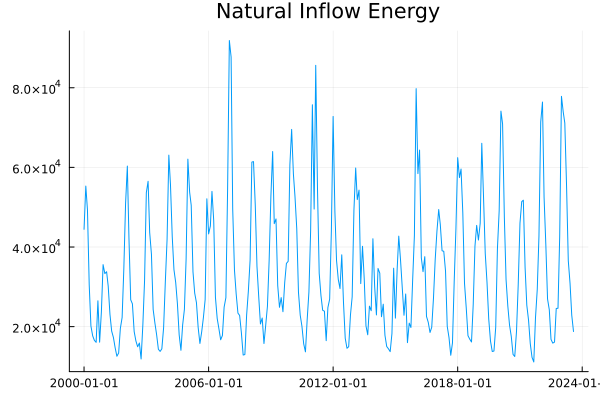

In [2]:
data = CSV.read("data/ena.csv", DataFrame)

y     = data[:, 2]
dates = data[:, 1]

plot(title = "Natural Inflow Energy")
plot!(dates, y, label = "")

## Defining and estimating a Score-Driven Model

Model specifications:
 - Distribution: tLocationScale
 - Only the mean parameter as time varying
 - d = 1
 - level component: random walk process
 - seasonality component: deterministic with 12 seasonal periods (monthly seasonality)
 - ar component: AR(2)

In [5]:
time_varying_parameters = [true, false, false]
dist                    = UnobservedComponentsGAS.tLocationScaleDistribution()
d                       = 1.0
num_scenarious          = 500

level       = "random walk"
seasonality = "deterministic 12"
ar          = 2

model = UnobservedComponentsGAS.GASModel(dist, time_varying_parameters, d, level,seasonality, ar)

UnobservedComponentsGAS.GASModel(UnobservedComponentsGAS.tLocationScaleDistribution(missing, missing, missing), Bool[1, 0, 0], 1.0, ["random walk", "", ""], ["deterministic 12", "", ""], Union{Missing, Int64}[2, missing, missing])

## Fit the model 

In [ ]:
fitted_model = UnobservedComponentsGAS.fit(model, y);

## Plot the fitted values

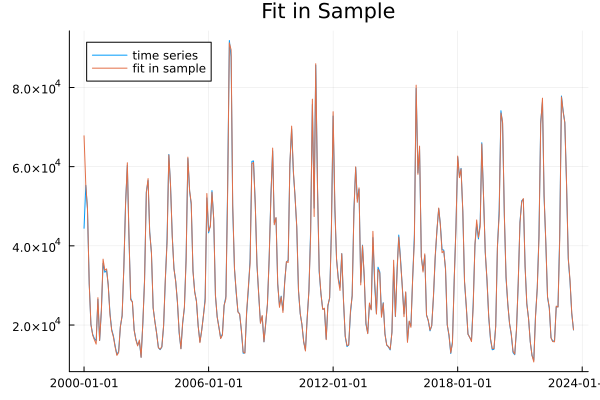

In [7]:
plot(title = "Fit in Sample")
plot!(dates, y, label = "time series")
plot!(dates,fitted_model.fit_in_sample, label = "fit in sample")

## How to acess every residual

The *fitted_model* object has a key *residuals* which is a dictionary containing 3 keys, one for each type of residuals:
 - **Standardized residuals**: contains a vector of the same length as the fitted time series
 - **Quantile residuals**: contains a vector of the same length as the fitted time series
 - **Conditional Score residuals**:  contains a matrix with as many rows as the length of the fitted time series and as many columns as the number of parameters of the chosen distribution.

Note that we have opted to exclude the initial element from all residuals. This decision was made because, frequently, the initial residual does not yield reliable information due to model initialization. In order to plot those residuals, we have also truncated the dates vector.

In [10]:
std_residuals               = fitted_model.residuals["std_residuals"][2:end]
quantile_residuals          = fitted_model.residuals["q_residuals"][2:end]
conditional_score_residuals = fitted_model.residuals["cs_residuals"][2:end,:]
cs_residuals_param_1        = conditional_score_residuals[:,1]
cs_residuals_param_2        = conditional_score_residuals[:,2]

residuals_dates             = dates[2:end];

### Auxiliary function to plot the autocorrelation function

Uses the StatsBase.jl autocor function.

In [11]:
function plot_acf(residuals, type)
    acf_values    = autocor(residuals)
    lags          = length(acf_values)
    lag_values    = collect(0:lags-1)
    conf_interval = 1.96 / sqrt(length(residuals)-1)  # 95% confidence interval

    p = plot(title="$type Residuals ACF")
    p = plot!(lag_values,acf_values,seriestype=:stem, label="",xticks=(lag_values,lag_values))
    p = hline!([conf_interval, -conf_interval], line = (:red, :dash), label = "IC 95%")
    return p
end

plot_acf (generic function with 1 method)

## Standardized Residuals

### Plot residuals

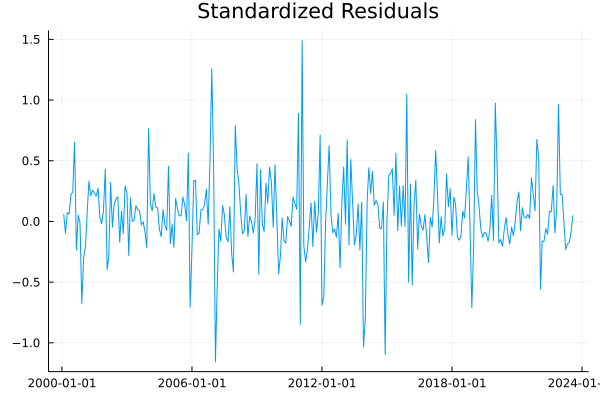

In [12]:
plot(title = "Standardized Residuals")
plot!(residuals_dates, std_residuals, label="")

### Plot Autocorrelation Function 

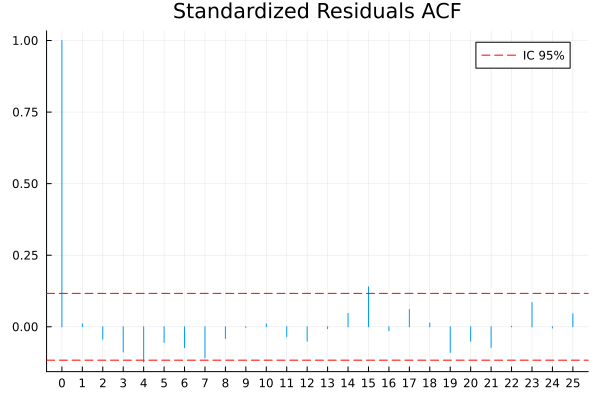

In [13]:
plot_acf(std_residuals, "Standardized")

### Plot QQPlot 

Used the StatsPlots.jl qqplot function.

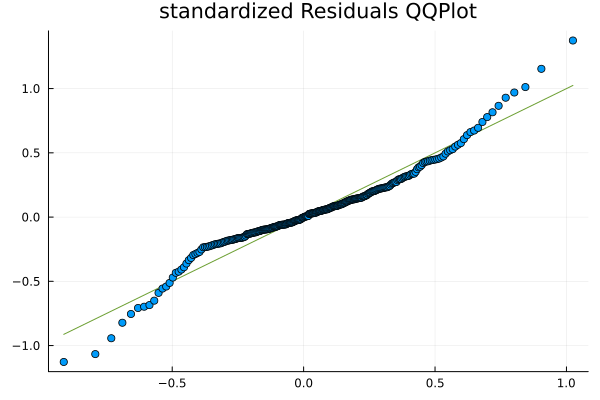

In [14]:
plot(qqplot(Normal, std_residuals))
plot!(title="standardized Residuals QQPlot")

### Jarque Bera Test for normality

Uses the HypothesisTests.jl JarqueBeraTest function.

In [15]:
JarqueBeraTest(std_residuals)

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.19019821262707104 and 6.001932681683795"

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-23

Details:
    number of observations:         283
    JB statistic:                   107.968


## Quantile Residuals

### Plot residuals

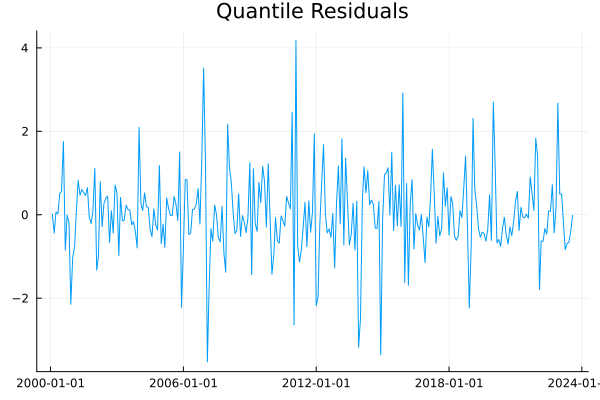

In [16]:
plot(title = "Quantile Residuals")
plot!(residuals_dates, quantile_residuals, label="")

### Plot Autocorrelation Function 

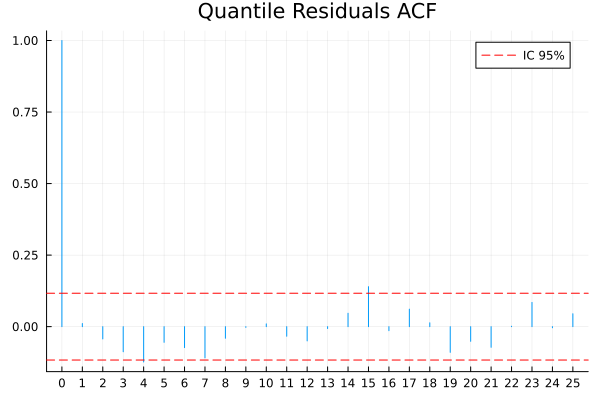

In [17]:
plot_acf(quantile_residuals, "Quantile")

### Plot QQPlot 

Used the StatsPlots.jl qqplot function.

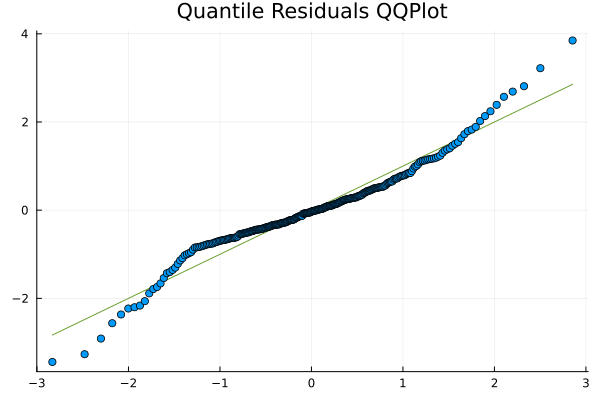

In [18]:
plot(qqplot(Normal, quantile_residuals))
plot!(title="Quantile Residuals QQPlot")

### Jarque Bera Test for normality

Uses the HypothesisTests.jl JarqueBeraTest function.

In [19]:
JarqueBeraTest(quantile_residuals)

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.18492031173132123 and 5.909783314924445"

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-22

Details:
    number of observations:         283
    JB statistic:                   101.451


## Conditional Score Residuals

### Plot Residuals

In this case, we have decided to plot the conditional score residuals for the 2 first parameters.

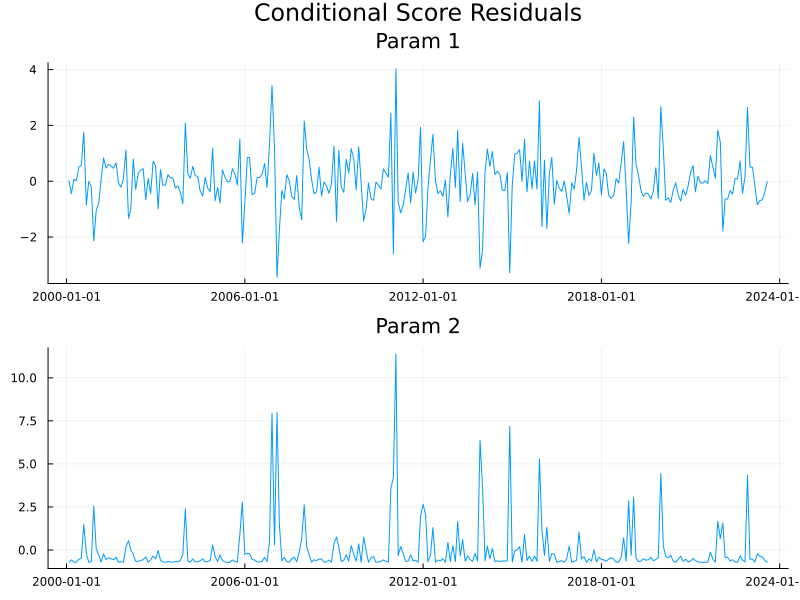

In [20]:
p1 = plot(residuals_dates, cs_residuals_param_1, label="")
p2 = plot(residuals_dates, cs_residuals_param_2, label="")
plot(p1, p2, layout = (2,1), size=(800,600),
    plot_title = "Conditional Score Residuals", title=["Param 1" "Param 2"])

### Plot Autocorrelation Funcion 

An astute user may observe a significant peak in the lag 12 of the autocorrelation function (ACF) of the second parameter, namely, the variance. Ideally, introducing time-varying dynamics to this parameter would be beneficial, but this functionality is still under development.

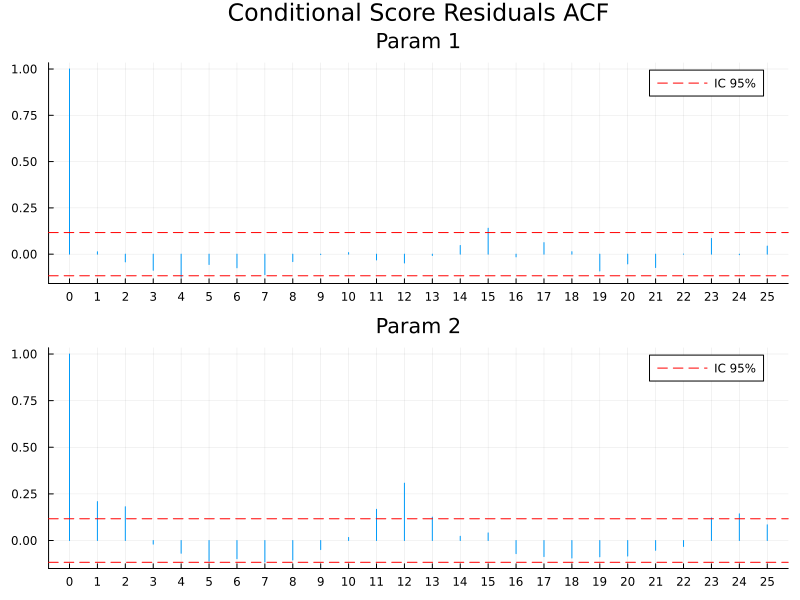

In [21]:
acf_plot_param_1 = plot_acf(cs_residuals_param_1, "Conditional Score")
acf_plot_param_2 = plot_acf(cs_residuals_param_2, "Conditional Score")

plot(acf_plot_param_1, acf_plot_param_2, layout = (2,1), size=(800,600),
    plot_title = "Conditional Score Residuals ACF", title=["Param 1" "Param 2"])